## Lesson 06 - GLMs, Linear Optimization and Clustering

Welcome to lesson 7! We will continue on with our application of what we have learned so far to statistical analysis of our data.

Today we will cover Generalised Linear Models (in the form of logistic regression), Linear Optimization using NumPy, and clustering using K-nearest neighbours in scikit-learn.

Download the [notebook here](/pythoncourse/assets/notebooks/r&d/lesson 06.ipynb).

### Generalised Linear Models

Linear models can be extended to fit certain non-linear data, using GLMs.

To do this, we need a 'link' function, which gives us a linear response. For today we will use a logistic regression, but we have a [wide array of link functions available](http://statsmodels.sourceforge.net/devel/glm.html#families).

We use logistic regression where we have a binomial output - 0 or 1. For example whether a patient is sick (1) or not (0) relates to their temperature (continuous), but not in a linear fashion.

Let's do some imports:

In [166]:
from pandas import Series, DataFrame
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

We will read in some college admissions data. This data shows whether an applicant was admitted to a college or not, their gre and gpa, and a categorical ranking of the college by 'prestige'.

We are interested in the relationship between admission, gpa, gre and prestige.

In [167]:
df = pd.read_csv("http://www.ats.ucla.edu/stat/data/binary.csv")
df.columns = ["admit", "gre", "gpa", "prestige"]
df.head()

,admit,gre,gpa,prestige
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


Pandas has a crosstab function, which is useful for tabulating data based on categorical variables. Here we tabulate admit and prestige, before plotting out our data.

In [3]:
pd.crosstab(df['admit'], df['prestige'], rownames=['admit'])

prestige,1,2,3,4
admit,,,,
0,28,97,93,55
1,33,54,28,12


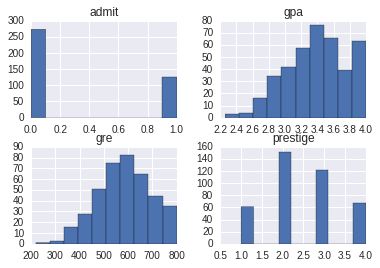

In [168]:
df.hist();

Now we can carry out our regression - we will model admission as a response of gre, prestige (as a categorical variable) and gpa.

To do this we can use the formula interface, similar to last week, and using the glm function with the family specified as Bionomial:

In [169]:
#using smf
logit = smf.glm('admit ~ gre + C(prestige) + gpa', family=sm.families.Binomial(), data = df)
print(logit.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  admit   No. Observations:                  400
Model:                            GLM   Df Residuals:                      394
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -229.26
Date:                Fri, 25 Mar 2016   Deviance:                       458.52
Time:                        09:57:37   Pearson chi2:                     397.
No. Iterations:                     6                                         
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -3.9900      1.140     -3.500      0.000        -6.224    -1.756
C(prestige)[T.2]    -0.6754      0

It is difficult to plot two continuous variables against each other: here we will use seaborn to plot the effects of gre and gpa seperately:

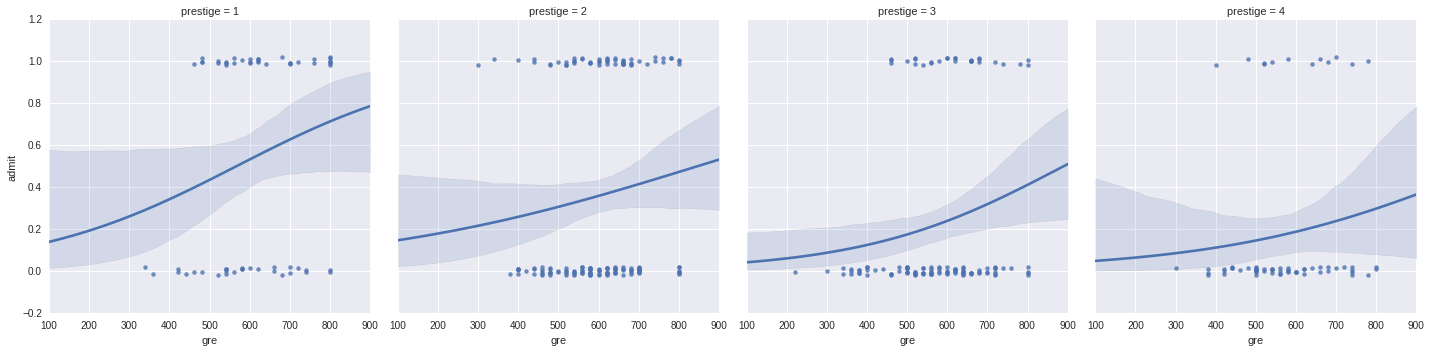

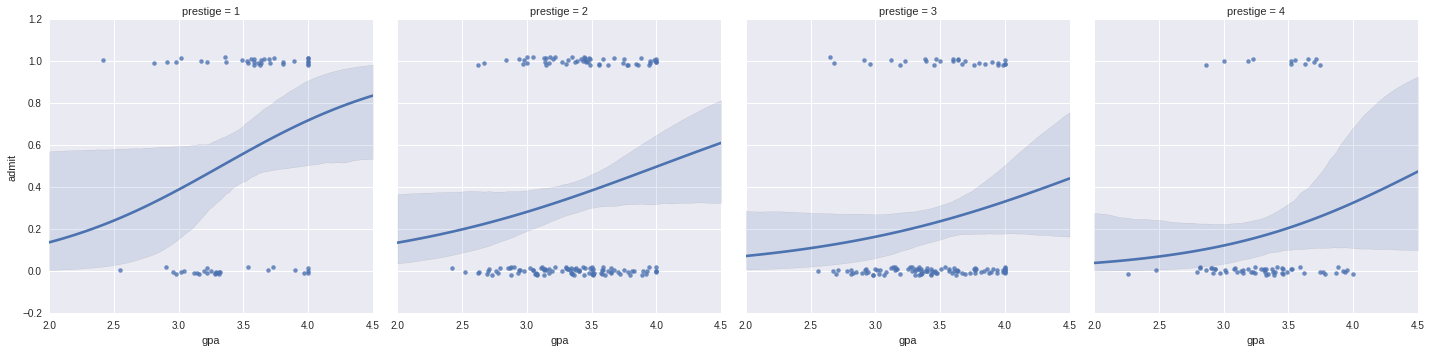

In [7]:
#plot
g = sns.lmplot(x="gre", y="admit", col="prestige", data=df, y_jitter=.02, logistic=True)
f = sns.lmplot(x="gpa", y="admit", col="prestige", data=df, y_jitter=.02, logistic=True)

To use the non-formula interface, we need to create dumm variables. Dummy variables allow us to treat categorical variables as 1s and 0s by adding on more factors:

In [170]:
#we can also do it using the non-formula interface:
dummy_ranks = pd.get_dummies(df['prestige'], prefix='prestige')
dummy_ranks.head()

,prestige_1,prestige_2,prestige_3,prestige_4
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0


To avoid multi-colinearity, we must remove one of the dummy variables.

We also need to manually add an intercept column if we wish to allow for an intercept term in our model

In [9]:
#remove the first dummy variable
df2 = df[['admit', 'gre', 'gpa']].join(dummy_ranks.ix[:, 'prestige_2':])
#manually add an intercept:
df2['intercept'] = 1.0
df2.head()

,admit,gre,gpa,prestige_2,prestige_3,prestige_4,intercept
0,0,380,3.61,0.0,1.0,0.0,1.0
1,1,660,3.67,0.0,1.0,0.0,1.0
2,1,800,4.00,0.0,0.0,0.0,1.0
3,1,640,3.19,0.0,0.0,1.0,1.0
4,0,520,2.93,0.0,0.0,1.0,1.0


In [187]:
logit = sm.GLM(df2['admit'], df2[df2.columns[1:]], family=sm.families.Binomial())
print(logit.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  admit   No. Observations:                  400
Model:                            GLM   Df Residuals:                      394
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -229.26
Date:                Fri, 25 Mar 2016   Deviance:                       458.52
Time:                        10:16:29   Pearson chi2:                     397.
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
gre            0.0023      0.001      2.070      0.038         0.000     0.004
gpa            0.8040      0.332      2.423      0.0

We can see that the results are the same. The choice of formula or non formula interface is up to you - use whichever you feel most comfortable with.

We can get our odds ratios out by calling .params and taking the exp:

In [198]:
#odds ratios
np.exp(logit.fit().params)

gre           1.002267
gpa           2.234545
prestige_2    0.508931
prestige_3    0.261792
prestige_4    0.211938
intercept     0.018500
dtype: float64

### Linear Optimization

Python has a variety of ways of carrying out linear optimization. We can either use the built in NumPy solver, or interface with a commercial or open source solver through Python.

[Gurobi](https://www.gurobi.com/documentation/6.5/refman/py_python_api_overview.html) and AMPL both offer Python apis, as well as [PuLP](http://www.coin-or.org/PuLP/) and [pyomo](http://www.pyomo.org/) which offer integration into a wide range of solvers. For use of these packages, see their help pages, as they have their own idiosyncracies. 

The main purpose of these interfaces is to get the data in from our equations and then run the solvers - We will use the built in solver in scipy, available in the scipy.optimize library:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html

In [12]:
from scipy.optimize import linprog

Imagine we are working for French's and we want to take advantage of the goodwill we have recently got from Canadian consumers.

We want to maxmise our profit on mustard and ketchup: We have 650 units of Canadian tomatoes, 1800 units of vinegar and 600 units of mustard seed available. We need 2 units of tomatoes and 4 of vinegar per pallet of ketchup, and 3 units of mustard seed and 7 units of vinegar per palette of mustard.

We can sell ketchup at \$400 per palette, and mustard at \$300 per palette.

We also have a limit on our new Canadian ketchup factory - we can produce at most 400 palettes of both products.

We also have to produce at lease 100 units of each product to protect our brand.

First let's state our constraints mathematically:

maximize:

* profit = 400 \* ketchup + 300 \* mustard
   
subject to: 

* ketchup \* 2 <= 650
   
* ketchup \* 4 + mustard \* 7 <= 1800
   
* mustard \* 3 <= 600 
   
* ketchup + mustard <= 400

* ketchup >= 100

* mustard >= 100

Let's plot out our system using our knowledge of matplotlib from last lesson:

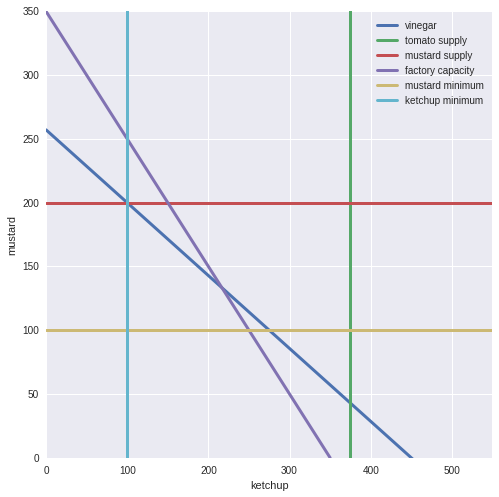

In [201]:
fig, ax = plt.subplots(figsize=(8, 8))
k = np.linspace(0, 1000)
m = np.linspace(0, 1000)
#vinegar supply
plt.plot(k, (1800 - k*4)/7, lw=3, label='vinegar')
#tomato supply
plt.plot(375 * np.ones_like(k), k, lw=3, label='tomato supply')
#mustard supply
plt.plot(m, 200 * np.ones_like(m), lw=3, label='mustard supply')
#factory limit
plt.plot((350 - k), k, lw=3, label='factory capacity')
#minimum mustard
plt.plot(m, 100 * np.ones_like(m), lw=3, label='mustard minimum')
#minimum ketchup
plt.plot(100 * np.ones_like(k), k, lw=3, label='ketchup minimum')
#set axis limits
ax.set(xlim=[0, 550], ylim = [0,350], ylabel = 'mustard', xlabel = 'ketchup')
#legend
plt.legend();

Now we need to specify our system to solve it.

To do this, we give an array, c, to be minimized, a 2D array (A) which gives the coefficients to be satisfied, and a 1D array with the upper bounds.

We can also optionally use equalities rather than upper bounds.

In [202]:
#optimize minimizes, so we take the negative of our values
c = [-400, -300]
#our input formula
A = [[2,0], [4,7], [0,3], [1,1], [-1,0], [0,-1]]
#our values
b = [650, 1800, 600, 350, -100, -100]
#bounds as a tuple
k_bounds = (0, 400)
#secondary bounds
m_bounds = (0, 400)
#linprog:
res = linprog(c, A_ub=A, b_ub=b, bounds=(k_bounds, m_bounds), options={"disp": True})

Optimization terminated successfully.
         Current function value: -130000.000000
         Iterations: 3


In [203]:
res

     fun: -130000.0
 message: 'Optimization terminated successfully.'
     nit: 3
   slack: array([ 150.,  100.,  300.,    0.,  150.,  300.,    0.,    0.])
  status: 0
 success: True
       x: array([ 250.,  100.])

In [165]:
250 * 400 + 100 * 300

130000

We can generalize this to multiple dimensions and variables! In scipy, we only have a simplex solver available, so to find faster and other solvers, try playing with pyomo and pulp. In general, these packages produce the same arrays to pass into the solvers from nicer inputs - the solvers and algorithms are the differences here.